# Collecting statistics on compiled benchmarks

In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper.lattice_surgery_schedule import LatticeSurgerySchedule
from swiper.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule, RandomTSchedule
from swiper.device_manager import DeviceManager
from swiper.window_builder import WindowBuilder
from swiper.window_manager import SlidingWindowManager
from swiper.decoder_manager import DecoderManager
from swiper.simulator import DecodingSimulator
import swiper.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

In [2]:
distance = 21
benchmark_info = pd.DataFrame(columns=['Space footprint', 'Ideal time', 'Ideal volume', 'Instruction count', 'T count', 'T volume', 'Merge count', 'Merge volume'])

for file in os.listdir('benchmarks/cached_schedules/'):
    if file.endswith('.lss'):
        schedule = LatticeSurgerySchedule.from_str(open('benchmarks/cached_schedules/' + file).read(), generate_dag_incrementally=True).full_schedule()
        schedule_name = file.split('.')[0]
        print(schedule_name)
        space_footprint = schedule.total_space_footprint()
        time_footprint = schedule.total_duration(distance) / distance
        volume = schedule.total_instruction_volume(distance) / distance
        t_count = schedule.count_instructions('INJECT_T')
        t_volume = (schedule.total_instruction_volume(distance, 'INJECT_T')+sum(instr.spacetime_volume(distance) for i,instr in enumerate(schedule.instructions) if instr.name=='CONDITIONAL_S' and len(instr.conditioned_on_idx) > 0)+sum(instr.spacetime_volume(distance) for i,instr in enumerate(schedule.instructions) if schedule.instructions[i-1].name=='INJECT_T' and instr.name=='MERGE')) / distance
        if t_count == 0:
            assert t_volume == 0
        # merge_count = schedule.count_instructions('MERGE')
        # merge_volume = schedule.total_instruction_volume(distance, 'MERGE') /
        # distance
        merge_count = sum(1 for i,instr in enumerate(schedule.instructions) if instr.name=='MERGE')
        merge_volume = sum(instr.spacetime_volume(distance) for i,instr in enumerate(schedule.instructions) if schedule.instructions[i-1].name!='INJECT_T' and instr.name=='MERGE')/distance
        instruction_count = t_count + merge_count + schedule.count_instructions('CONDITIONAL_S') + schedule.count_instructions('IDLE')

        benchmark_info.loc[schedule_name] = [space_footprint, time_footprint, volume, instruction_count, t_count, t_volume, merge_count, merge_volume]

grover_ancilla_5
carleman_2_4
msd_15to1
qpeexact_10
memory_10000
H2
random_t_10000_200_0
rz_1e-15
random_t_1000_200_0
fermi_hubbard_4_4_Square
rz_1e-10
qft_10
rz_1e-05
rz_1e-20
heisenberg_3
fermi_hubbard_2_2_Square
qrom_15_15
toffoli
rz_seq_10_1e-10
fermi_hubbard_2_2_Kagome
adder_n18
qpeexact_5
rz_seq_100_1e-10
regular_t_1000_0


In [3]:
benchmark_info['density'] = benchmark_info['Ideal volume'] / (benchmark_info['Space footprint'] * benchmark_info['Ideal time'])

In [4]:
benchmark_info['T instruction ratio'] = benchmark_info['T count']*3 / (benchmark_info['Instruction count'])

In [5]:
benchmark_info.to_csv('benchmarks/benchmark_info.csv')

In [6]:
benchmark_info.sort_values('T count', ascending=False)

,Space footprint,Ideal time,Ideal volume,Instruction count,T count,T volume,Merge count,Merge volume,density,T instruction ratio
grover_ancilla_5,34.0,32523.142857,124129.428571,69510.0,13577.0,56790.000000,34923.0,43328.000000,0.112254,0.585973
heisenberg_3,107.0,31937.142857,151551.285714,66673.0,12833.0,82394.000000,34035.0,46523.000000,0.044349,0.577430
qft_10,86.0,13352.571429,124047.428571,60026.0,11484.0,63298.000000,30346.0,39954.000000,0.108025,0.573951
qpeexact_10,85.0,14076.857143,124645.142857,59340.0,11378.0,64886.000000,29964.0,39190.000000,0.104172,0.575228
rz_seq_100_1e-10,4.0,33353.285714,86714.571429,49725.0,10004.0,40016.000000,24863.0,29718.000000,0.649970,0.603560
random_t_10000_200_0,3.0,73338.571429,109052.857143,49942.0,10000.0,30000.000000,20000.0,20000.000000,0.495659,0.600697
fermi_hubbard_4_4_Square,225.0,10384.428571,77864.428571,25816.0,3993.0,28612.000000,15555.0,42089.000000,0.033325,0.464015
fermi_hubbard_2_2_Kagome,181.0,8785.428571,51785.142857,19974.0,3340.0,23792.000000,11376.0,21984.000000,0.032566,0.501652
H2,92.0,7543.857143,39912.000000,16037.0,3084.0,23288.000000,8214.0,11208.000000,0.057507,0.576916
qpeexact_5,34.0,5224.285714,23494.285714,12100.0,2363.0,11690.000000,6088.0,7634.000000,0.132268,0.585868


In [7]:
t_vol_ratio = benchmark_info['T volume'] / benchmark_info['Ideal volume']
merge_vol_ratio = benchmark_info['Merge volume'] / benchmark_info['Ideal volume']

/var/folders/vy/pypq_bm52_50g15jqc51yyr80000gp/T/ipykernel_36910/1555390596.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.annotate(txt, (t_vol_ratio[i], merge_vol_ratio[i])))


Text(42.847222222222214, 0.5, 'Merge volume ratio')

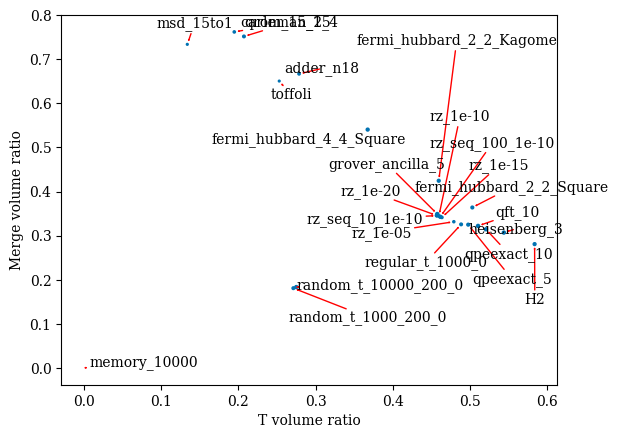

In [8]:
# scatter plot: x = t_vol_ratio, y = merge_vol_ratio, size = instruction count
# label each point with name
import adjustText
plt.figure()
plt.scatter(t_vol_ratio, merge_vol_ratio, s=np.log10(benchmark_info['Instruction count']))
texts = []
for i, txt in enumerate(benchmark_info.index):
    texts.append(plt.annotate(txt, (t_vol_ratio[i], merge_vol_ratio[i])))
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), force_text=(0.1,0.5), max_move=None)
plt.xlabel('T volume ratio')
plt.ylabel('Merge volume ratio')